# Quantum Phase Estimation

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit.circuit.library import QFT
# from qiskit_aer import AerSimulator, StatevectorSimulator
# from qiskit_ibm_provider import IBMProvider
# aer_sim = AerSimulator()
# aer_sim = StatevectorSimulator()
# backend = aer_sim
# backend = quantum_hardware
# qc_trans = transpile(circuit, backend, initial_layout=layout, optimization_level=2)

## Objective

The quantum phase estimation algorithm (QPE) is very key for many quantum algorithms. It's goal is to find the eigenvalue of some given eigenstate of a unitary operator. In this problem we are given two things: a unitary operator $U$ and one of its eigenvalues $|\psi\rangle$. As we have previously discussed, because it is a unitary operator, we can write

$$U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$$

where $0\leq\varphi<1$. Our goal is to estimate the eigenvalue and thus the phase $\varphi$ of $|\psi\rangle$. Just like with the Hadamard test, the phase of $U$ is written onto our control qubits. But because this is in the Fourier basis, we apply the inverse $\text{QFT}$ to transform it to the computational basis to perform a measurement. Recall from the $\text{QFT}$ section that in the Fourier basis the topmost qubit completes one rotation when counting from $0$ to $2^n$ where $n$ is the number of control qubits. For example, to count to some number $x$ between $0$ and $2^n$, the rotation of the first three qubits $R_{q_{n}}$ around the $z$-axis is as follows:

$$R_{q_0} = \frac{x}{2^n} \qquad R_{q_1} = \frac{2x}{2^n} \qquad R_{q_2} = \frac{4x}{2^n}$$

When performing a controlled-$U$ operation, as we mentioned before, the qubit will proportionally rotate to the phase $e^{2\pi i \varphi}$. In order to correctly encode the phase $\varphi$ (a number between $0$ and $2^n$), we can apply $C-U$ gates in succession to repeat this rotation a number of times until the phase $\varphi$ has been applied in the Fourier basis. Then by using the inverse $\text{QFT}$ we transform it to the computational basis for measurement.  

## Proof

Let's walk through the math of this procedure and how it is implemented as a circuit. We start with some state $|\psi\rangle$ as one set of qubit registers and $n$ counting qubits making up the counting register. Because all of our qubits start in the state $|0\rangle$, we can represent the initial state of our circuit as

$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle$$

To put each counting qubit into superposition we then apply a Hadamard gate to all $n$ qubits putting our circuit in the state

$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle$$

We then apply our $C-U$ gates. Since we already know that $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, when applying this gate to all $n$ qubits, it then follows that 

$$U^{2^j}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{2\pi i \varphi}|\psi\rangle = U^{2^{j}-2}e^{4\pi i \varphi}|\psi\rangle = \dots = e^{2\pi i 2^j \varphi}|\psi\rangle$$

Therefore, by controlling this gate and applying it to all $n$ qubits, we must apply $C-U^{2^j}$ where $0 \leq j \leq n-1$. This leaves us with

$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right)\otimes \left(|0\rangle + e^{2\pi i \varphi 2^{n-2}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle\otimes|\psi\rangle$$

Here, $k$ is the integer representation of $n$-bit binary numbers.

show that we can measure phase using inverse qft (similar process to proving qft)

## Verification

In [3]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        qc.measure(i,i)

In [4]:
ancilla_bits = 6
angle = 0.35

In [5]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.35
Binary Representation of the phase angle:  0.010110


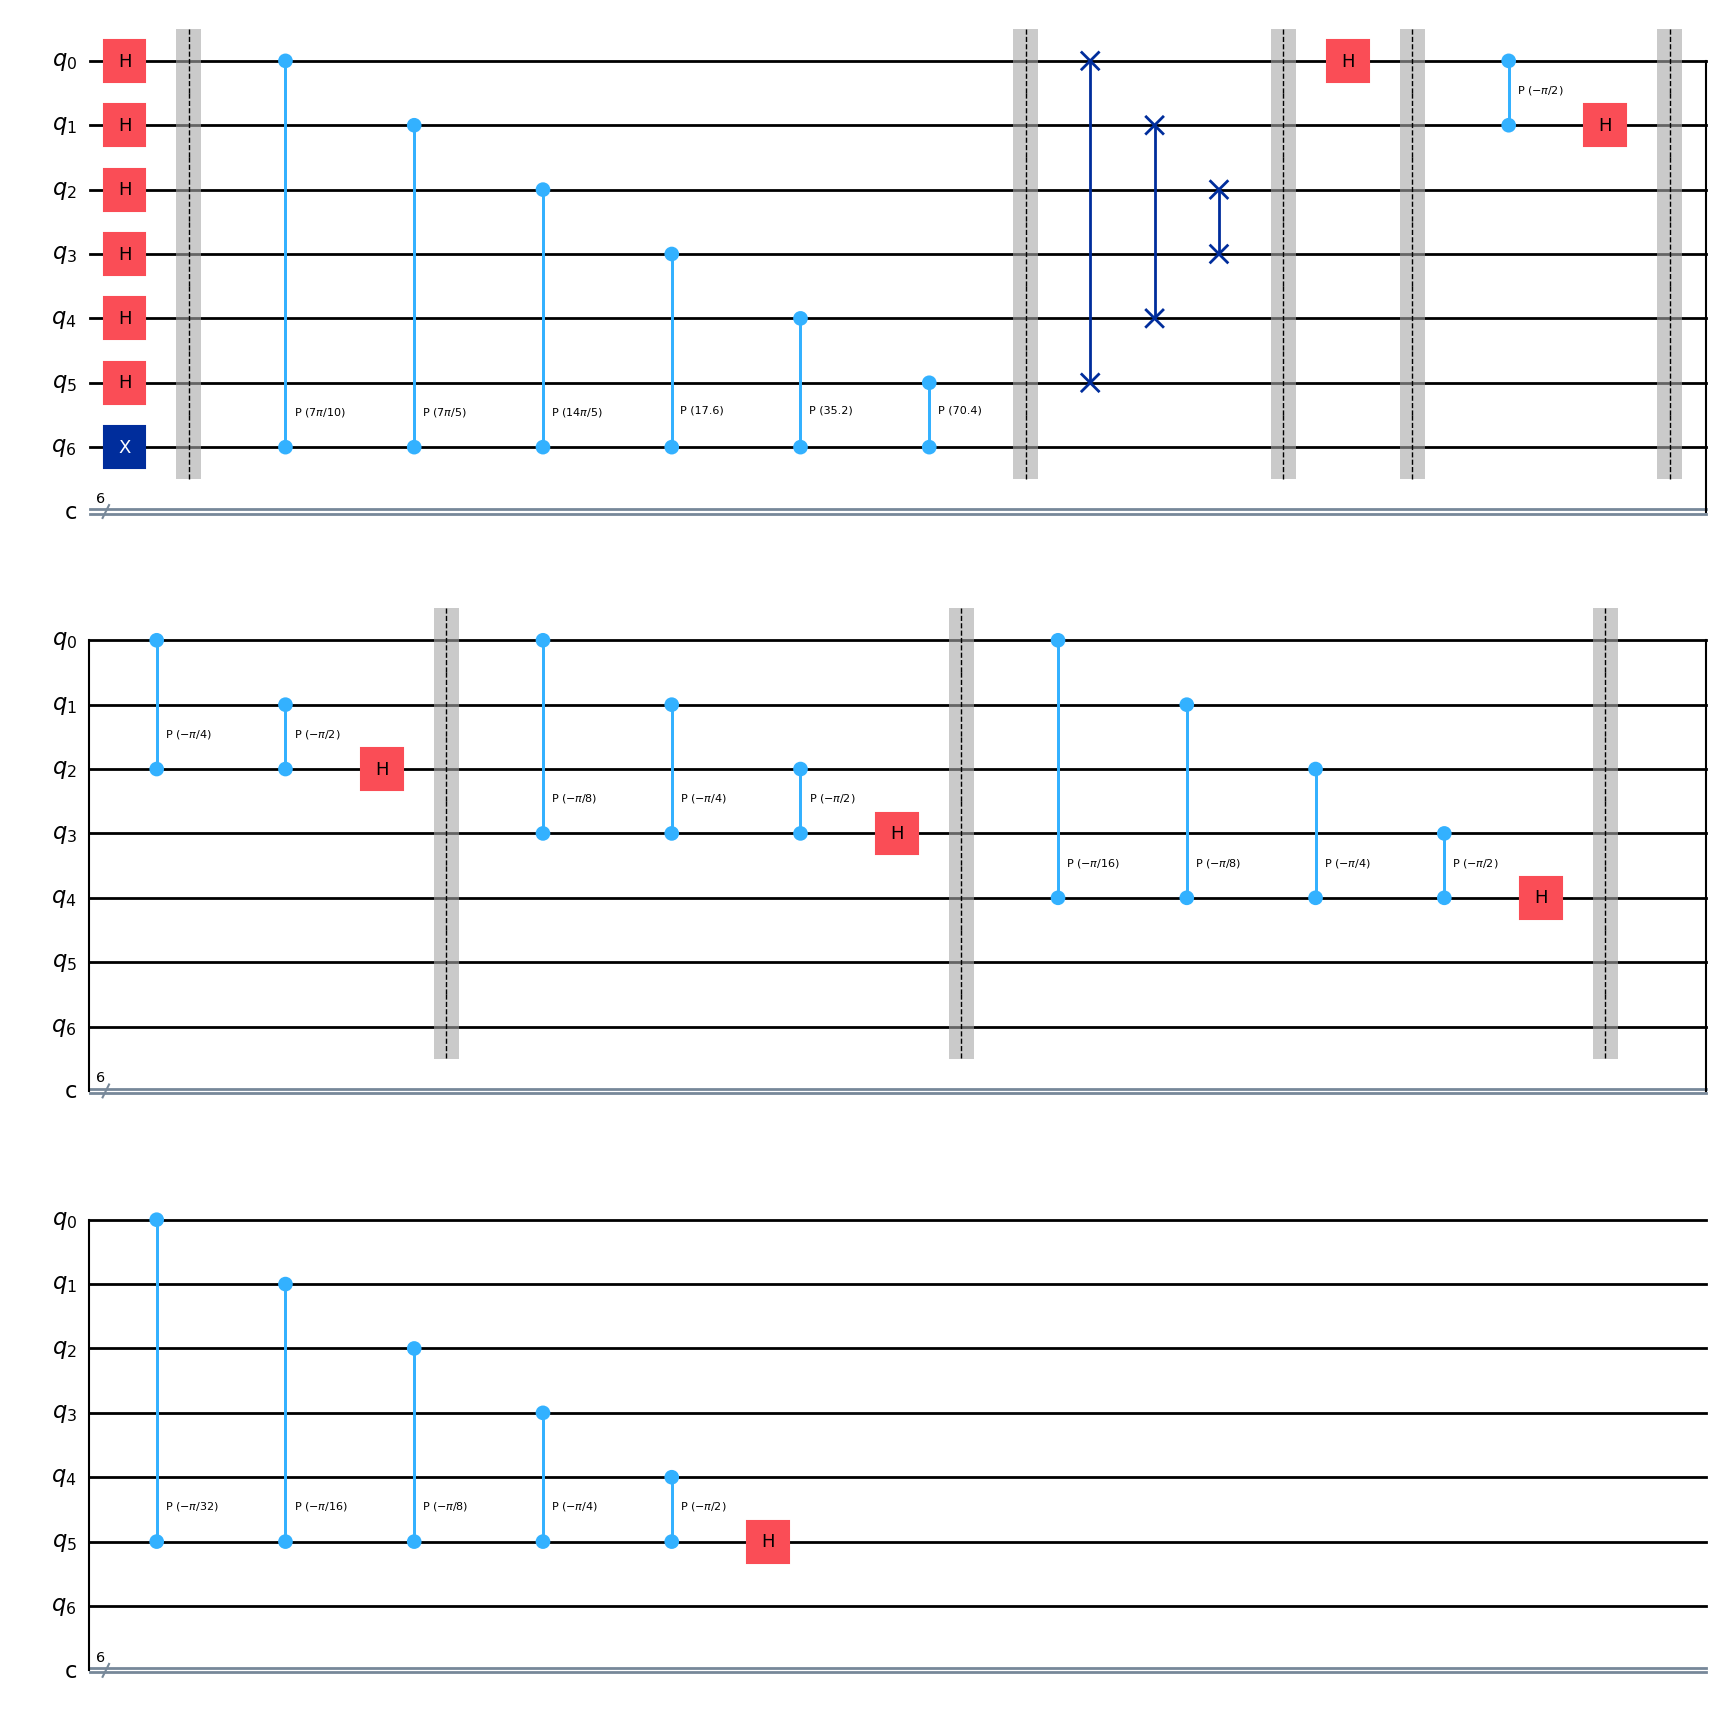

In [120]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)

# qr_ancilla = QuantumRegister(ancilla_bits)
# print(qr_ancilla

# qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

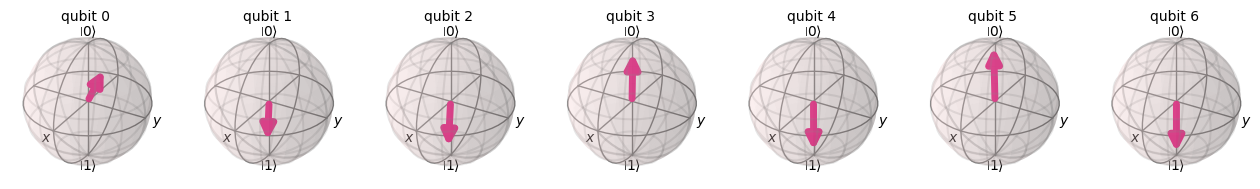

In [121]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

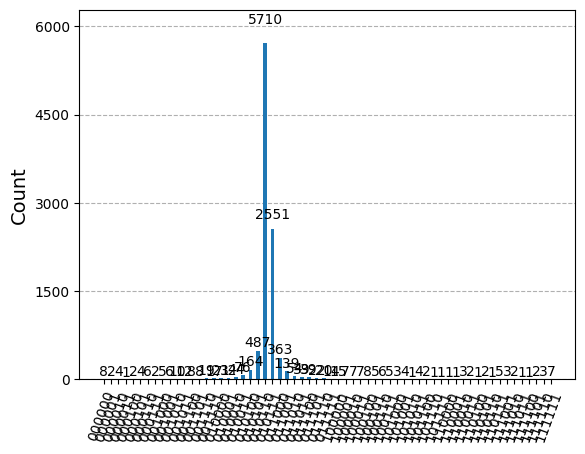

In [122]:
measure(qc, ancilla_bits)
backend = BasicSimulator()
result = backend.run(qc, shots=10000).result()   
counts = result.get_counts()                    
plot_histogram(counts)


In [123]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.010110
Decimal Number with Equivalent Value: 0.34375


### Using QPE to check the Phase of a Matrix

QPE isn't restricted to checking the phase of a single qubit, it also can be used for checking the phase of a matrix. The phase of a matrix represents an eigenvalue of that matrix. 

In general a matrix will not be hermitian, so to make it Hermitian we normalize it. To normalize we determine the size of the matrix then divide every element in that matrix by that size. This will scale every value in the matrix to be at max 1.

Since eigenvalues can be negative and we can't measure negative probabilies, we need to shift all the eigenvalues to be positive. We can do this by adding a factor to every value on the diagonal of the matrix.

We plug in the vector we want to find the energy of.

For example, lets us use the Hamiltonian from the Ising Model.
$$ H = -\sum_{i=0}^{n-1} Z_iZ_{i+1} - g\sum_{i=0}^nX_i $$ 

In [168]:
eigen_bits = 6
g = 0
ancilla_bits = 6

In [169]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

# construct the Hamiltonian
# with Pauli Operators in Qiskit ^ represents a tensor product
print("H = ", end='')
for i in range(eigen_bits-1):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i or j == i+1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    print("-"+str(temp)+" ", end='')
    H += -temp.to_matrix()
for i in range(eigen_bits):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i):
            temp ^= Pauli('X')
        else:
            temp ^= Pauli('I')
    print("-g"+str(temp)+" ", end='')
    H += -g*temp.to_matrix()
print("\n")

# print(H.real)

# normalize the Hamiltonian
H = (np.pi/8)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += pi/4*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)



# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

# print("Hamiltonian for Ising Model:\n",H)

# def is_unitary_matrix(matrix):
#     return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)
# print(is_unitary_matrix(H))

H = -ZZIIII -IZZIII -IIZZII -IIIZZI -IIIIZZ -gXIIIII -gIXIIII -gIIXIII -gIIIXII -gIIIIXI -gIIIIIX 

Eigenvalues of the Hamiltonian:
 [0.39269908+0.j 0.54977871+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 1.02101761+0.j 1.17809725+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.54977871+0.j 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 1.17809725+0.j 1.02101761+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.54977871+0.j 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.54977871+0

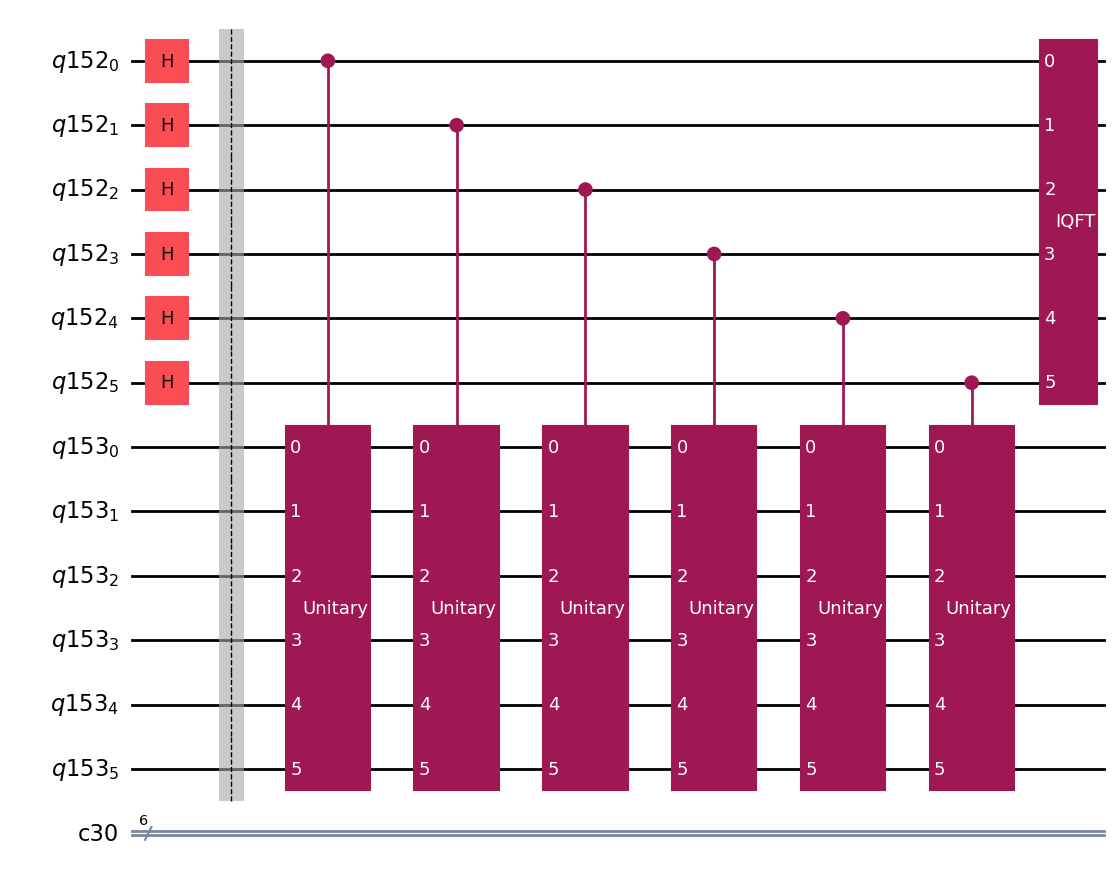

In [170]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

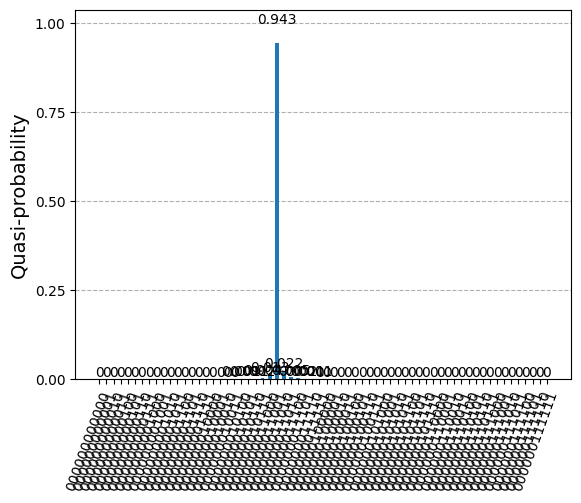

In [171]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
plot_histogram(ideal_distribution)

In [172]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.39269908169872414
Binary Number Output: 0.011001
Decimal Number with Equivalent Value: 0.390625


When applying the QPE method on a quantum computer, so far we have assumed that both $|\psi\rangle$ is an eigenstate and its phase $\varphi$ has some $d$-bit binary representation. In general, when practically applying this method neither of these conditions can be exactly satsified. To this end it is necessary to analyze this effect on the error of the QPE. So what happens when these conditions are not exactly met? First, as before we assume a unitary operator $U$ has the eigendecomposition 

$$U|\psi_j \rangle = e^{i2\pi \varphi_j}|\psi_j\rangle$$

We assume $0\leq \varphi_0 \leq \varphi_1 \dots \leq \varphi_{N-1}\leq 1$ where we are interested in using QPE to find the phase of the groundstate $\varphi_0$. 

In order to analyze the error, we first relax the first condition, meaning the second condition is assumed to be exactly true. This means that all $\varphi_i$'s have an exact $d$-bit binary representation, but the quantum state is given by some linear combination

$$|\phi\rangle = \sum_{k\in[N]}c_k|\psi_k\rangle$$

where the probability of the ground state is $p_0 = |\langle\phi|\psi_0\rangle|^2 = |c_0|^2 < 1$.

Then applying the QPE procedure to $t$ ancilla qubits and the quantum state $|\phi\rangle$ where $t=d$ because $\varphi$ is represented by a $d$-bit binary number (QPE applied to $|0^t\rangle|\phi\rangle$), measuring the ancilla qubits then returns the binary representation of $\varphi_0$ with probability $p_0$. The system register containing the quantum state also returns the eigenstate $|\psi_0\rangle$ with probability $p_0$. However, in order to realize that $\varphi_0$ is actually the desired phase, some sort of background knowledge of the location of $\varphi_0$ is necessary. For example we must know $\varphi_0 \in (\alpha, \beta)$ and $\varphi_i > \beta$ for all $i \neq 0$. It may then be desirable to relax both of the conditions, discussed above, but this requires a much more involved analysis and additional assumptions. 

To simplify this analysis, we will only consider the case in which the second condition is violated meaning $\varphi_0$ cannot be exactly represented by some binary $d$-bit number. In this case the QPE circuit is still applied to an initial state $|0^t\rangle|\phi\rangle$ but with $t>d$. Taking the converted estimated binary phase to base 10 as $\tilde{\varphi}_{k'} = \frac{k'}{2^t}$ and applying the QPE to this state gives

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle e^{i2\pi j\varphi_0}|\psi_0\rangle \xrightarrow{\text{QFT}^{\dagger}} \sum_{k'\in[2^t]}\left(\frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}\right)|k'\rangle|\psi_0\rangle$$


Looking at this expression we can clearly see that this is exactly applying the forward followed by the inverse $\text{QFT}$ on the state. For simplicity, we say

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QPE}} \sum_{k'}\gamma_{0,k'}|k'\rangle|\psi_0\rangle \ , \quad \gamma_{0,k'} = \frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}$$

Recognizing that $\gamma_{0,k'}$ is a gemotric series with the common ratio $r = e^{i2\pi \left(\varphi_0 - \frac{k'}{2^t}\right)}$, this can be further simplified by

$$\gamma_{0,k'} = \frac{1}{2^t}\frac{1-r^{2^t}}{1-r} = \frac{1}{2^t}\frac{1-e^{i\pi 2^{t+1} \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}{1-e^{i2\pi \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}$$

From this expression we can tell that for the case in which $\varphi_0$ has an exact $d$-bit representation meaning $\varphi_0 = \tilde{\varphi}_{k_0'}$ for some $k_0'$, then $\gamma_{0,k'} = \delta_{k',k_0'}$ the Dirac delta function as shown in $\text{Fig.}: ?$. This is to say that if there is an exact $d$-bit representation of the phase $\varphi_0$, one run of the QPE circuit will give the value $\varphi_0$ deterministically. Now assume that $\varphi_0 \neq \tilde{\varphi}_{k'}$ for any $k'$. Since $e^{i2\pi x}$ is a periodic function with a period of $1$, we can only find the value of $x \mod{1}$. Therefore, when estimating the phase $k_0'$ we are aiming for precision $\epsilon = \frac{1}{2^d} = \frac{2^{t-d}}{2^t}$ such that 

$$\left|\varphi_0-\tilde{\varphi}_{k_0'}\right|_1<\epsilon$$

Using the relationship that for any $\theta \in [-\pi,\pi]$

$$\left|1-e^{i\theta}\right| = \left|(1-\cos\theta)-i\sin\theta\right| = \sqrt{(1-\cos\theta)^2 + \sin\theta} = \sqrt{2(1-\cos\theta)} = 2\left|\sin\frac{\theta}{2}\right|\geq\frac{2}{\pi}\left|\theta\right|$$

and that

$$\left|1 - e^{i\theta}\right| \leq \left|1\right| + \left|e^{i\theta}\right| = \sqrt{1^2} + \sqrt{\cos^2\theta - (i\sin\theta)^2} = 1 + \sqrt{\cos^2\theta + \sin^2\theta} = 1 + 1 = 2$$

we find that 

$$\left|\gamma_{0,k'}\right| \leq \frac{2}{2^t2\pi\frac{2}{\pi}\left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1} = \frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1} $$

In [173]:
ancilla_bits = 6
angle = 0.35

In [174]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.35
Binary Representation of the phase angle:  0.010110


In [175]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)
#qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))

In [176]:
measure(qc, ancilla_bits)
backend = BasicSimulator()
result = backend.run(qc, shots=10000).result()   
counts = result.get_counts()                    

kvals = []
binaries = []
for key in counts:
    binaries.append(key)
for num in binaries:
    decimal = 0
    for i in range(len(num)):
        decimal += int(num[i])/2**(i+1)
    kvals.append(decimal)
kvals = np.sort(np.array(kvals))

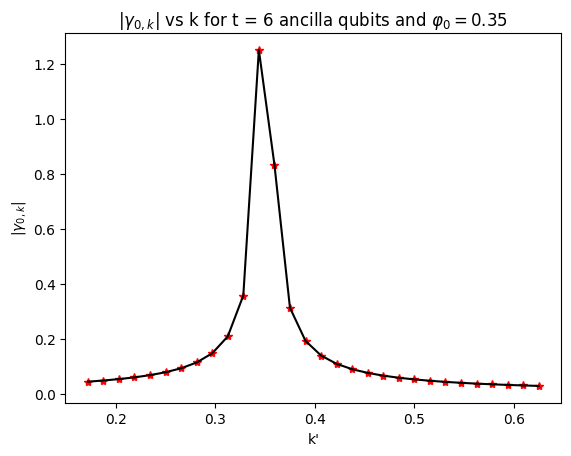

In [177]:
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
plt.plot(kvals[10:40], gamma[10:40], 'r*')
plt.plot(kvals[10:40], gamma[10:40], 'k-')
plt.xlabel("k'")
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title('$|\u03B3_{0,k}|$ vs k for t = 6 ancilla qubits and $\u03c6_0 = 0.35$')
plt.show()

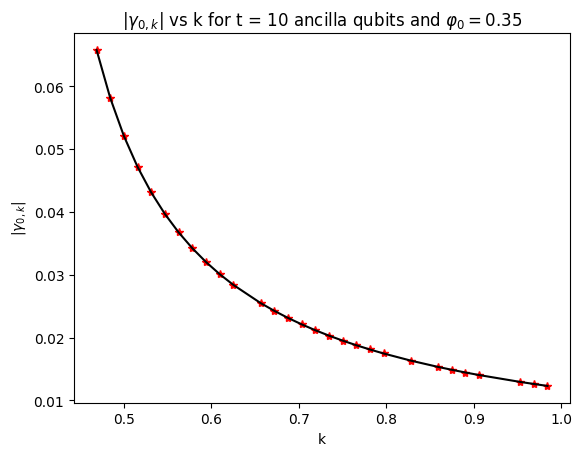

In [29]:
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
plt.plot(kvals[30:75], gamma[30:75], 'r*')
plt.plot(kvals[30:75], gamma[30:75], 'k-')
plt.xlabel('k')
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title('$|\u03B3_{0,k}|$ vs k for t = 10 ancilla qubits and $\u03c6_0 = 0.35$')
plt.show()

The value of the measurement outcome $k_0'$ can be viewed as a random variable where the probability of obtaining some $\tilde{\varphi}_{k_0'}$ that is at least a distance $\epsilon$ away from the expected value $\varphi_0$ is 

$$ P\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) = \sum_{\left|\varphi_0 - \tilde{\varphi}_{k'}\right|\geq\epsilon}\left|\gamma_{0,k'}\right|^2 \leq \left|\frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}\right|^2 =  \frac{1}{4T^2\left|\varphi_0 -\tilde{\varphi}_{k'}\right|^2_1}$$

where $T = 2^t$. By using an integral approximation of the sum and setting $x^2 = \left|\varphi_0 - \tilde{\varphi}_{k'}\right|^2_1$

$$\leq \frac{2}{4T}\int_\epsilon^\infty \frac{1}{x^2}dx + \frac{2}{4T^2\epsilon^2} = \frac{1}{2T\epsilon}+\frac{1}{2\left(T\epsilon\right)^2}$$

By then setting $t-d = \log_2{(\delta^{-1})}$, because $T\epsilon = 2^{t-d} \Rightarrow \log_2{(T\epsilon)} = t - d$, therefore $T\epsilon = \delta ^{-1}$. So aiming for a $0<\delta<1$, the failure probability is 

$$ P\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) \leq \frac{1}{2T\epsilon}+\frac{1}{2\left(T\epsilon\right)^2}  = \frac{\delta}{2} + \frac{\delta^2}{2} = \frac{\delta + \delta^2}{2} \leq \delta$$

In order to obtain the phase $\varphi_0$ to an accuracy of $\epsilon = \frac{1}{2^t}$ with a success probability of at least $1-\delta$, a total of $t = d + \log_2{(\delta^{-1})}$ ancilla qubits are neccessary to store the phase value. Furthermore, because $T\epsilon = \delta^{-1}$, the run time of the simulation must be $T = (\epsilon\delta)^{-1}$